In [1]:
# TOBIT
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df = pd.read_csv("/Users/tobitlouis/Downloads/S27FE-10K.csv")

X = df.drop('realized_volatility', axis=1).values
y = df['realized_volatility'].values
y = np.log1p(y)  # log-transform

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create overlapping time windows
def create_windows(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 60
X_seq, y_seq = create_windows(X_scaled, y, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [ ]:
# FOR REGULAR LSTM TRAINING 

# Datasets and loaders
batch_size = 64
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# -------------------
# Define LSTM Model
# -------------------

class LSTMVolatility(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout_rate=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # x: (batch, time, features)
        out = lstm_out[:, -1, :]  # Take last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze()

# -------------------
# Train Model
# -------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMVolatility(input_size=X_seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.6f}")

# -------------------
# Evaluate Model
# -------------------

model.eval()
y_preds_log, y_trues_log = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        y_preds_log.extend(preds.cpu().numpy())
        y_trues_log.extend(y_batch.numpy())

# Invert log transform
y_preds = np.expm1(y_preds_log)
y_trues = np.expm1(y_trues_log)

mse = mean_squared_error(y_trues, y_preds)
r2 = r2_score(y_trues, y_preds)
print(f"\nFinal Evaluation:")
print(f"  MSE: {mse:.8f}")
print(f"  R^2: {r2:.4f}")

# -------------------
# Plot Predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([min(y_trues), max(y_trues)], [min(y_trues), max(y_trues)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("LSTM - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()



📂 Fold 1/5
  R^2: 0.9070, MSE: 0.00000032

📂 Fold 2/5
  R^2: 0.8328, MSE: 0.00000064

📂 Fold 3/5
  R^2: 0.8959, MSE: 0.00000031

📂 Fold 4/5
  R^2: 0.7430, MSE: 0.00000091

📂 Fold 5/5
  R^2: 0.8656, MSE: 0.00000045

✅ LSTM Cross-Validation Summary:
  Avg R²:  0.8489 ± 0.0589
  Avg MSE: 0.00000053 ± 0.00000022


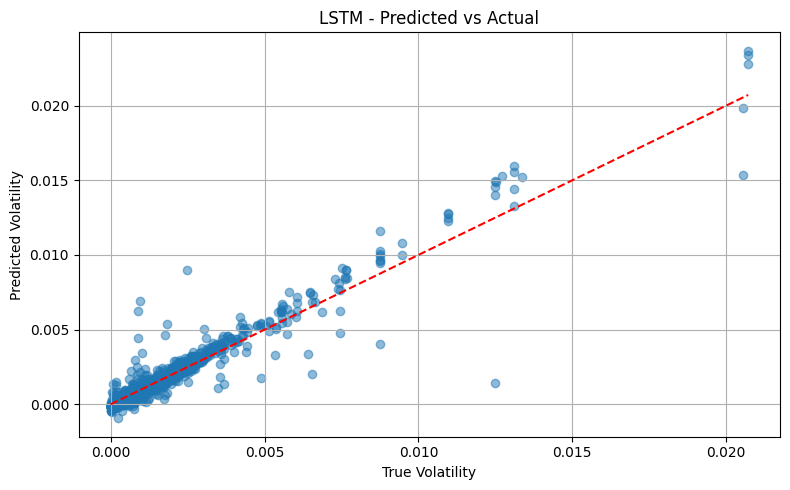

In [6]:
# FOR CROSS-VALIDATION
from sklearn.model_selection import KFold

# K-Fold setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

r2_scores = []
mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n📂 Fold {fold+1}/{k_folds}")

    # Split fold data
    X_train_fold, X_val_fold = X_seq[train_idx], X_seq[val_idx]
    y_train_fold, y_val_fold = y_seq[train_idx], y_seq[val_idx]

    # Dataloaders
    train_dataset = TensorDataset(torch.Tensor(X_train_fold), torch.Tensor(y_train_fold))
    val_dataset = TensorDataset(torch.Tensor(X_val_fold), torch.Tensor(y_val_fold))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # New model each fold
    model = LSTMVolatility(input_size=X_seq.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(20):  # Use 20–50 epochs for CV
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    val_preds_log, val_trues_log = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            val_preds_log.extend(preds.cpu().numpy())
            val_trues_log.extend(y_batch.numpy())

    # Invert log1p
    val_preds = np.expm1(val_preds_log)
    val_trues = np.expm1(val_trues_log)

    mse = mean_squared_error(val_trues, val_preds)
    r2 = r2_score(val_trues, val_preds)
    mse_scores.append(mse)
    r2_scores.append(r2)
    print(f"  R^2: {r2:.4f}, MSE: {mse:.8f}")

# Final summary
print("\n LSTM Cross-Validation Summary:")
print(f"  Avg R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"  Avg MSE: {np.mean(mse_scores):.8f} ± {np.std(mse_scores):.8f}")

# -------------------
# Plot Predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([min(y_trues), max(y_trues)], [min(y_trues), max(y_trues)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("LSTM - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100 - Loss: 0.000222
Epoch 2/100 - Loss: 0.000034
Epoch 3/100 - Loss: 0.000016
Epoch 4/100 - Loss: 0.000010
Epoch 5/100 - Loss: 0.000006
Epoch 6/100 - Loss: 0.000005
Epoch 7/100 - Loss: 0.000003
Epoch 8/100 - Loss: 0.000003
Epoch 9/100 - Loss: 0.000002
Epoch 10/100 - Loss: 0.000002
Epoch 11/100 - Loss: 0.000001
Epoch 12/100 - Loss: 0.000001
Epoch 13/100 - Loss: 0.000001
Epoch 14/100 - Loss: 0.000001
Epoch 15/100 - Loss: 0.000001
Epoch 16/100 - Loss: 0.000001
Epoch 17/100 - Loss: 0.000001
Epoch 18/100 - Loss: 0.000001
Epoch 19/100 - Loss: 0.000001
Epoch 20/100 - Loss: 0.000001
Epoch 21/100 - Loss: 0.000001
Epoch 22/100 - Loss: 0.000001
Epoch 23/100 - Loss: 0.000001
Epoch 24/100 - Loss: 0.000000
Epoch 25/100 - Loss: 0.000000
Epoch 26/100 - Loss: 0.000000
Epoch 27/100 - Loss: 0.000000
Epoch 28/100 - Loss: 0.000000
Epoch 29/100 - Loss: 0.000000
Epoch 30/100 - Loss: 0.000000
Epoch 31/100 - Loss: 0.000000
Epoch 32/100 - Loss: 0.000000
Epoch 33/100 - Loss: 0.000000
Epoch 34/100 - Loss

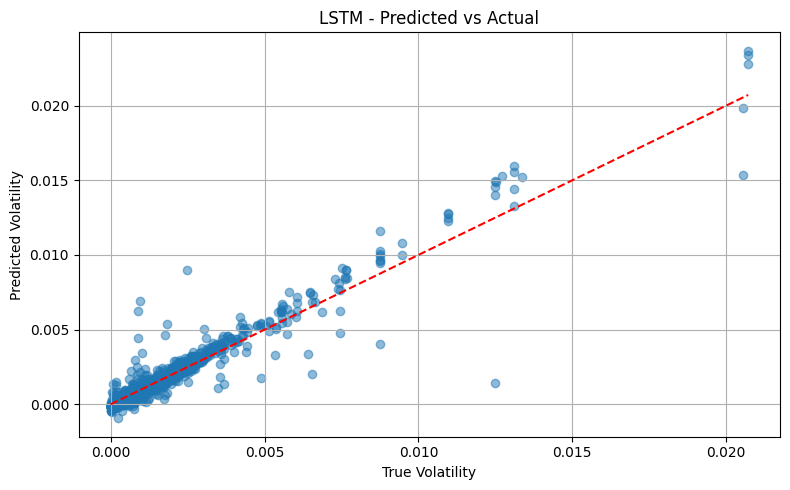